In [1326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from sklearn.cluster import KMeans

%matplotlib inline

In [1327]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
#https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [1328]:
df.tail()

id  gender   age  hypertension  heart_disease ever_married  \
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0

In [1329]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [1330]:
#odstranění příznaku "id"
ID = df.pop("id")

In [1331]:
# identifikace typu jednotlivých příznaků
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [1332]:
# % zastoupení nemocných pacientů v datasetu  
a = sum(df.heart_disease.values)/len(df.index)
b = sum(df.hypertension.values)/len(df.index)
c = sum(df.stroke.values)/len(df.index)

print(" S onemocněním srdce: ", round(a*100, 2), "\n",
     "S hypertenzí: ", round(b*100, 2), "\n", 
     "Po mrtvici: ", round(c*100, 2))


 S onemocněním srdce:  5.4 
 S hypertenzí:  9.75 
 Po mrtvici:  4.87


<AxesSubplot:xlabel='bmi', ylabel='Count'>

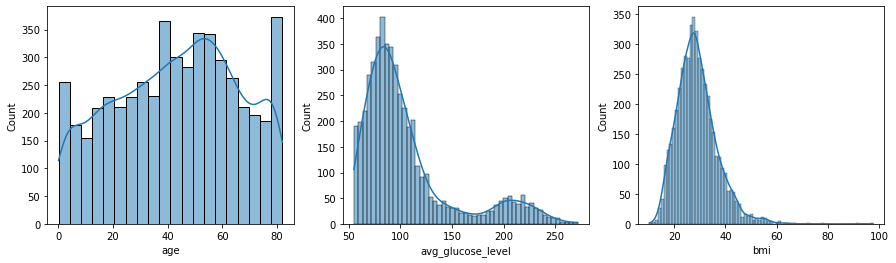

In [1333]:
#distribuce dat v rámci numerických příznaků
fig, axs = plt.subplots(ncols= 3, figsize=(15,4))

sns.histplot(data=df, x="age", kde=True, ax=axs[0])
sns.histplot(data=df, x="avg_glucose_level", kde=True, ax=axs[1])
sns.histplot(data=df, x="bmi", kde=True, ax=axs[2])


## Chybějící hodnoty

In [1334]:
#detekce chybějících hodnot
df = df.fillna(np.nan)
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

NaN hodnoty v rámci příznaku BMI: 
Jelikož mám >5000 řádek dat a z toho jen 200 (~4%) řádek obsahuje chybějící BMI, asi bych dala přednost odstranění těchto řádků před nahrazením hodnoty např. za průměr.

In [1335]:
#index_NaN_bmi = list(df['bmi'][df['bmi'].isnull()].index)
#for i in index_NaN_bmi:
#    df = df.drop(labels = i, axis = 0)

Při alternativě doplňování chybějících hodnot bych vzala v potaz fakt, že BMI souvisí s věkem.

In [1336]:
df.corr()

age  hypertension  heart_disease  avg_glucose_level  \
age                1.000000      0.276398       0.263796           0.238171   
hypertension       0.276398      1.000000       0.108306           0.174474   
heart_disease      0.263796      0.108306       1.000000           0.161857   
avg_glucose_level  0.238171      0.174474       0.161857           1.000000   
bmi                0.333398      0.167811       0.041357           0.175502   
stroke             0.245257      0.127904       0.134914           0.131945   

                        bmi    stroke  
age                0.333398  0.245257  
hypertension       0.167811  0.127904  
heart_disease      0.041357  0.134914  
avg_glucose_level  0.175502  0.131945  
bmi                1.000000  0.042374  
stroke             0.042374  1.000000

<AxesSubplot:xlabel='age', ylabel='bmi'>

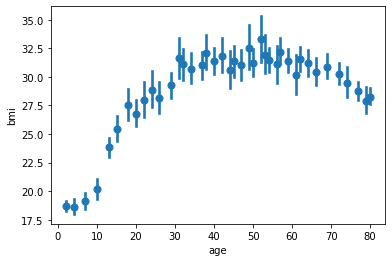

In [1337]:
sns.regplot(x="age", y="bmi", data=df, x_bins=40, fit_reg = False)

In [1338]:
print(min(df["age"]))
print(max(df["age"]))

0.08
82.0


In [1339]:
# kategorizace numerických hodnot "věk"
bins= [0,15,25,35,45,55, 65, 75, 85]
labels = ['0-15','16-25','26-35','36-45','46-55', '56-65', "66-75", "76-85"]
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

[Text(0, 0, '0-15'),
 Text(1, 0, '16-25'),
 Text(2, 0, '26-35'),
 Text(3, 0, '36-45'),
 Text(4, 0, '46-55'),
 Text(5, 0, '56-65'),
 Text(6, 0, '66-75'),
 Text(7, 0, '76-85')]

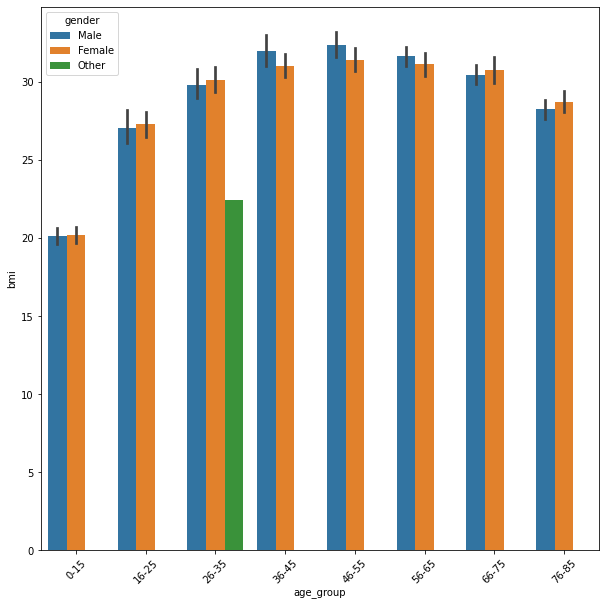

In [1340]:
# bmi podle věkové skupiny
plt.figure(figsize=(10,10))
fig = sns.barplot(x="age_group", y="bmi", data=df, hue = "gender")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)


In [1341]:
# nahrazení chybějících hodnot "bmi" podle mediánu věkové kategorie
index_NaN_bmi = list(df['bmi'][df['bmi'].isnull()].index)

for i in index_NaN_bmi:
    bmi_pred = (df['bmi'][(df['age_group'] == df.iloc[i]['age_group'])].median())
    df['bmi'].loc[i] = bmi_pred    

/Users/zuzka/opt/miniconda3/envs/VZD/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/zuzka/opt/miniconda3/envs/VZD/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/zuzka/opt/miniconda3/envs/VZD/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

/Users/zuzka/opt/miniconda3/envs/VZD/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/zuzka/opt/miniconda3/envs/VZD/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/zuzka/opt/miniconda3/envs/VZD/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [1342]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_group            0
dtype: int64


## Kategorická data

<AxesSubplot:xlabel='gender', ylabel='Count'>

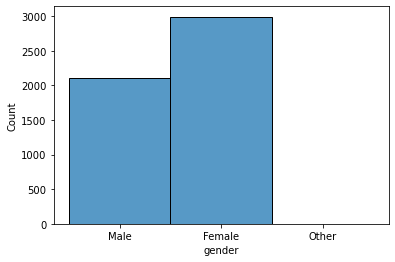

In [1343]:
sns.histplot(data=df, x="gender")

In [1344]:
df[df['gender'] == "Other"]

gender   age  hypertension  heart_disease ever_married work_type  \
3116  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  \
3116          Rural             143.33  22.4  formerly smoked       0   

     age_group  
3116     26-35

In [1345]:
#odstranění pohlaví "other"
df.drop(labels = 3116, axis = 0, inplace = True)

In [1346]:
df[['gender', 'stroke']].groupby(['gender'], as_index=False).mean()

gender    stroke
0  Female  0.047094
1    Male  0.051064

<AxesSubplot:xlabel='ever_married', ylabel='Count'>

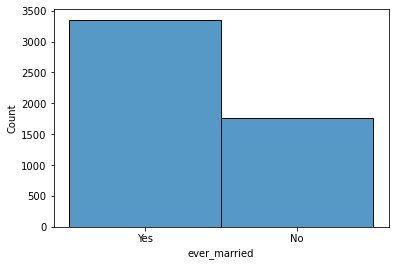

In [1347]:
sns.histplot(data=df, x="ever_married")

In [1348]:
df[["ever_married", 'stroke']].groupby(['ever_married'], as_index=False).mean()

ever_married    stroke
0           No  0.016515
1          Yes  0.065613

<AxesSubplot:xlabel='Residence_type', ylabel='Count'>

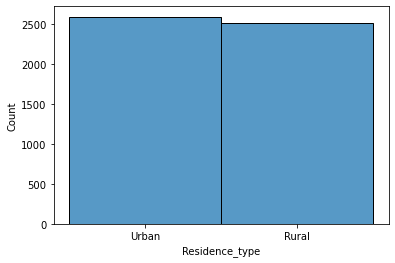

In [1349]:
sns.histplot(data=df, x="Residence_type")

In [1350]:
df[["Residence_type", 'stroke']].groupby(['Residence_type'], as_index=False).mean()

Residence_type    stroke
0          Rural  0.045364
1          Urban  0.052003

In [1351]:
# nahrazení kategorických příznaků o 2 kategoriích za binární
df['sex'] = 0
df.loc[df['gender'] == 'Female', 'sex'] = 1

df['married'] = 0
df.loc[df['ever_married'] == 'Yes', 'married'] = 1

df['residence'] = 0
df.loc[df['Residence_type'] == 'Urban', 'residence'] = 1

<AxesSubplot:xlabel='smoking_status', ylabel='Count'>

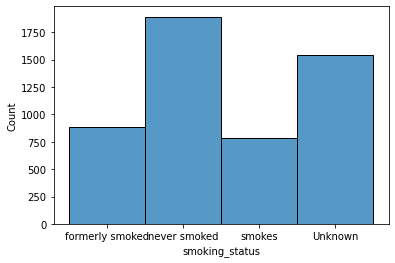

In [1352]:
sns.histplot(data=df, x="smoking_status")

In [1353]:
df[["smoking_status", 'stroke']].groupby(['smoking_status'], as_index=False).mean()

smoking_status    stroke
0          Unknown  0.030440
1  formerly smoked  0.079186
2     never smoked  0.047569
3           smokes  0.053232

In [1354]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [1355]:
# one-hot-encoding příznaku smoking_status
df['FS'] = 0
df.loc[df['smoking_status'] == 'formerly smoked', 'FS'] = 1

df['NS'] = 0
df.loc[df['smoking_status'] == 'never smoked', 'NS'] = 1

df['S'] = 0
df.loc[df['smoking_status'] == 'smokes', 'S'] = 1

<AxesSubplot:xlabel='work_type', ylabel='Count'>

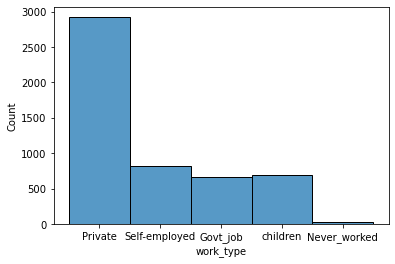

In [1356]:
sns.histplot(data=df, x="work_type")

In [1357]:
df[["work_type", 'stroke']].groupby(['work_type'], as_index=False).mean()

work_type    stroke
0       Govt_job  0.050228
1   Never_worked  0.000000
2        Private  0.050958
3  Self-employed  0.079365
4       children  0.002911

In [1359]:
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke age_group  \
0          Urban             228.69  36.6  formerly smoked       1     66-75   
1          Rural             202.21  30.4     never smoked       1     56-65   
2          Rural             105.92  32.5     never smoked       1     76-85   
3          Urban             171.23  34.4           smokes       1     46-55   
4          Rural             174.12  24.0     never smoked       1     76-85   

   sex  married  residence  FS  NS  S  
0    0        1          1   1   0  0  
1    1        1          0   0   1  0  
2    0        1          0   0   1  0  
3    1        1          1   0   0  1  
4    1        1          0   0   1  0

# Korelační matice

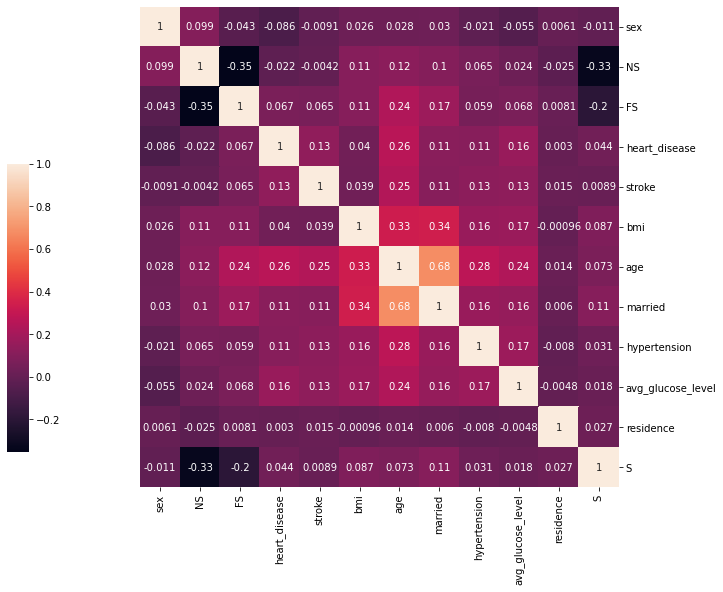

In [1360]:
cp = sns.clustermap(df.corr(), annot=True, cbar_pos=(0, .2, .03, .4))
cp.ax_row_dendrogram.set_visible(False)
cp.ax_col_dendrogram.set_visible(False)

Text(0.5, 1.0, 'Stroke')

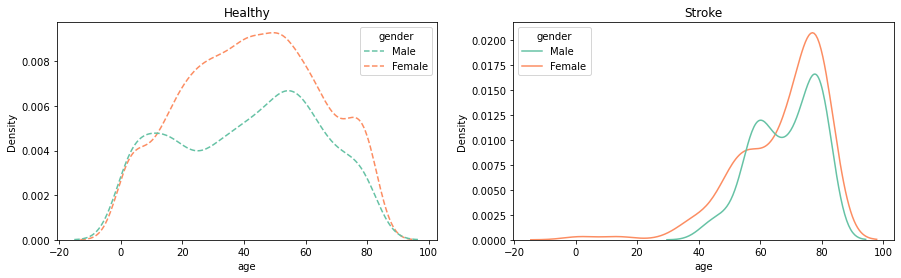

In [1361]:
# korelační analýza naznačila vliv věku na incidenci mrtvice
# distribuce věku pacientů po mrtvici:
fig, axs = plt.subplots(ncols= 2, figsize=(15,4))

sns.kdeplot(data = df[df["stroke"]==0], x='age', hue='gender', linestyle="--", palette="Set2", ax = axs[0]).set_title('Healthy')
sns.kdeplot(data = df[df["stroke"]==1], x='age', hue='gender', palette="Set2", ax = axs[1]).set_title('Stroke')


In [1362]:
stroke_age_heart = df[['age_group', 'stroke', "heart_disease", "sex"]].groupby(['age_group', "sex"], as_index=False).mean()
stroke_age_heart

age_group  sex    stroke  heart_disease
0       0-15    0  0.000000       0.002717
1       0-15    1  0.006042       0.000000
2      16-25    0  0.000000       0.000000
3      16-25    1  0.000000       0.000000
4      26-35    0  0.000000       0.004785
5      26-35    1  0.002506       0.002506
6      36-45    0  0.008000       0.008000
7      36-45    1  0.011416       0.004566
8      46-55    0  0.025157       0.062893
9      46-55    1  0.039583       0.022917
10     56-65    0  0.091954       0.114943
11     56-65    1  0.051980       0.044554
12     66-75    0  0.114679       0.215596
13     66-75    1  0.109966       0.099656
14     76-85    0  0.206030       0.261307
15     76-85    1  0.191223       0.163009

# Klasifikace mrtvice

In [1363]:
y = df["stroke"]

In [1364]:
# výběr příznaků
dc = df.corr()
dc.loc["stroke"]

age                  0.245239
hypertension         0.127891
heart_disease        0.134905
avg_glucose_level    0.131991
bmi                  0.039086
stroke               1.000000
sex                 -0.009081
married              0.108299
residence            0.015415
FS                   0.064683
NS                  -0.004163
S                    0.008920
Name: stroke, dtype: float64

In [1365]:
col_list = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "FS", "married", "residence"]
X = df[col_list]

In [1366]:
X.head()

age  hypertension  heart_disease  avg_glucose_level   bmi  FS  married  \
0  67.0             0              1             228.69  36.6   1        1   
1  61.0             0              0             202.21  30.4   0        1   
2  80.0             0              1             105.92  32.5   0        1   
3  49.0             0              0             171.23  34.4   0        1   
4  79.0             1              0             174.12  24.0   0        1   

   residence  
0          1  
1          0  
2          0  
3          1  
4          0

In [1545]:
# vytvoření trénovacích, validačních a testovacích datasetů
X_train, X_data, y_train, y_data = train_test_split(X, y, test_size=0.3, random_state=40, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=40)

## Decission Tree

In [1546]:
#ladění parametru maximální hloubky stromu
test_acc, val_acc, train_acc = [],[],[]
depths = range(1,20)
for depth in depths:
    a = DecisionTreeClassifier(max_depth=depth)
    a = a.fit(X_train, y_train)
    y_pred_test = a.predict(X_test)
    y_pred_train = a.predict(X_train)
    y_pred_val = a.predict(X_val)
    train_acc.append(metrics.accuracy_score(y_train, y_pred_train))
    test_acc.append(metrics.accuracy_score(y_test, y_pred_test))
    val_acc.append(metrics.accuracy_score(y_val, y_pred_val))

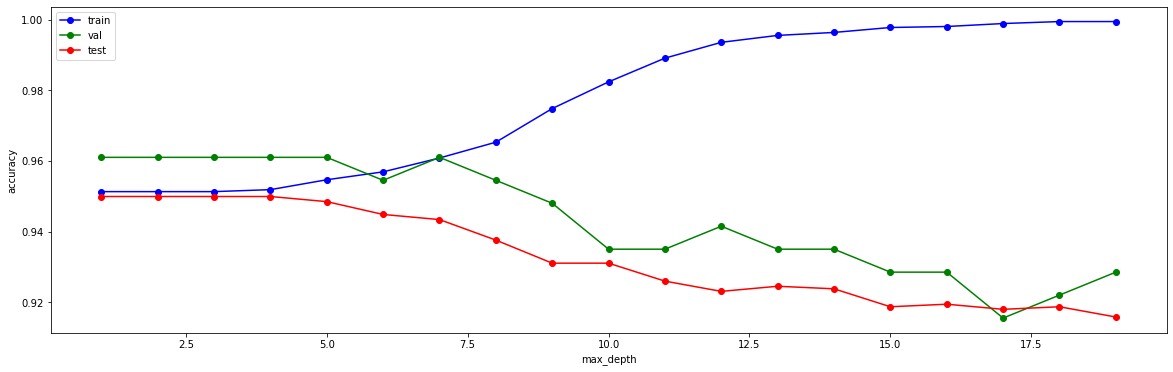

In [1547]:
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'ob-')
plt.plot(depths, val_acc,'og-')
plt.plot(depths, test_acc,'or-')
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend(["train", "val","test"])

In [1548]:
# klasifikace při hloubce stromu = 4
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_val = clf.predict(X_val)

print('Train Accuracy: ', np.round(metrics.accuracy_score(y_train, y_pred_train), 4))
print('Validation Accuracy: ', np.round(metrics.accuracy_score(y_val, y_pred_val), 4))
print('Test Accuracy: ', np.round(metrics.accuracy_score(y_test, y_pred_test), 4))

Train Accuracy:  0.9519
Validation Accuracy:  0.961
Test Accuracy:  0.95


[Text(418.5, 733.86, 'age <= 57.5\ngini = 0.093\nsamples = 3576\nvalue = [3402, 174]\nclass = healthy'),
 Text(209.25, 570.78, 'age <= 44.5\ngini = 0.026\nsamples = 2508\nvalue = [2475, 33]\nclass = healthy'),
 Text(104.625, 407.70000000000005, 'avg_glucose_level <= 58.115\ngini = 0.008\nsamples = 1767\nvalue = [1760, 7]\nclass = healthy'),
 Text(52.3125, 244.62, 'avg_glucose_level <= 58.055\ngini = 0.075\nsamples = 51\nvalue = [49, 2]\nclass = healthy'),
 Text(26.15625, 81.54000000000008, 'gini = 0.039\nsamples = 50\nvalue = [49, 1]\nclass = healthy'),
 Text(78.46875, 81.54000000000008, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = stroke'),
 Text(156.9375, 244.62, 'age <= 37.5\ngini = 0.006\nsamples = 1716\nvalue = [1711, 5]\nclass = healthy'),
 Text(130.78125, 81.54000000000008, 'gini = 0.001\nsamples = 1383\nvalue = [1382, 1]\nclass = healthy'),
 Text(183.09375, 81.54000000000008, 'gini = 0.024\nsamples = 333\nvalue = [329, 4]\nclass = healthy'),
 Text(313.875, 407.700000000000

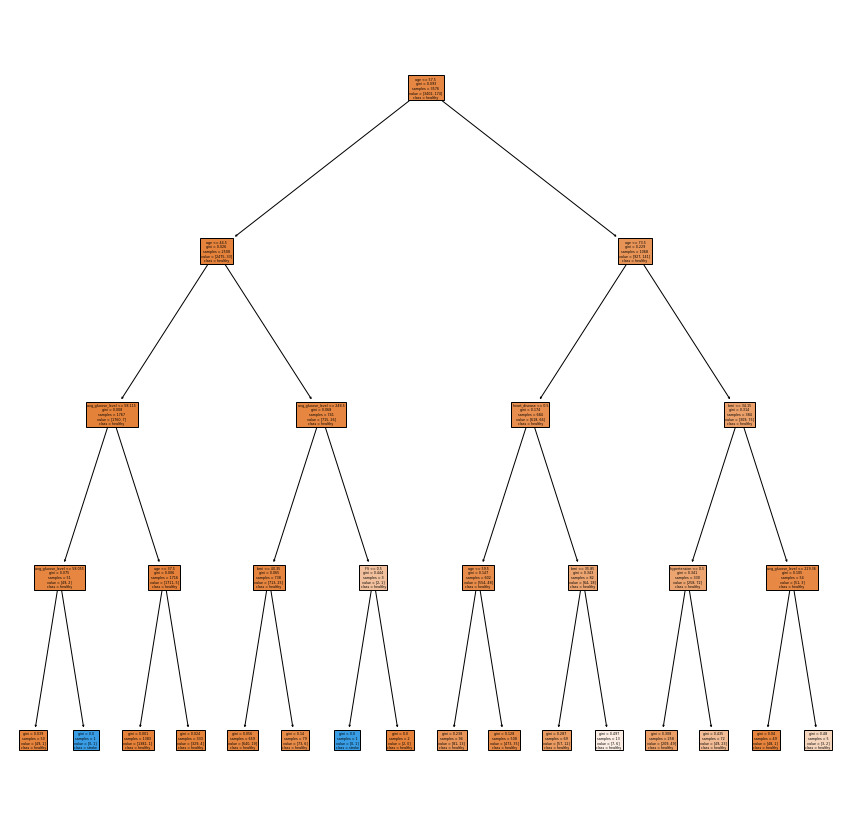

In [1549]:
plt.figure(figsize=(15,15))
tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=["healthy", "stroke"])

# Srovnání klasifikátorů

In [1588]:
# srovnání klasifikátorů podle přesnosti klasifikace testovacích dat
# chvilku to trvá
m_depth = 4
classifiers = []
classifiers.append(DecisionTreeClassifier(max_depth = m_depth))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=1))
classifiers.append(RandomForestClassifier(max_depth = m_depth))
classifiers.append(AdaBoostClassifier(RandomForestClassifier(),learning_rate=1))
classifiers.append(CatBoostClassifier(max_depth = m_depth, silent = True))
classifiers.append(LGBMClassifier(max_depth = m_depth))
classifiers.append(XGBClassifier(max_depth = m_depth, use_label_encoder=False))

test_acc = []
numbers = [1,13,23,28,55]
for number in numbers:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=number, stratify = y)
    for classifier in classifiers :
        x = classifier.fit(X_train, y_train)
        y_pred_test = x.predict(X_test)
        test_acc.append(metrics.accuracy_score(y_test, y_pred_test))
   
name = ["DecisionTree","AB_DecisionTree",
        "RandomForest","AB_RandomForest",
        "CatBoost","LGBM","XGB"]*len(numbers)

adf = pd.DataFrame(list(zip(name, test_acc)), columns =['classifier', 'test_accuracy'])

[19:24:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:24:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[Text(0, 0, 'DecisionTree'),
 Text(1, 0, 'AB_DecisionTree'),
 Text(2, 0, 'RandomForest'),
 Text(3, 0, 'AB_RandomForest'),
 Text(4, 0, 'CatBoost'),
 Text(5, 0, 'LGBM'),
 Text(6, 0, 'XGB')]

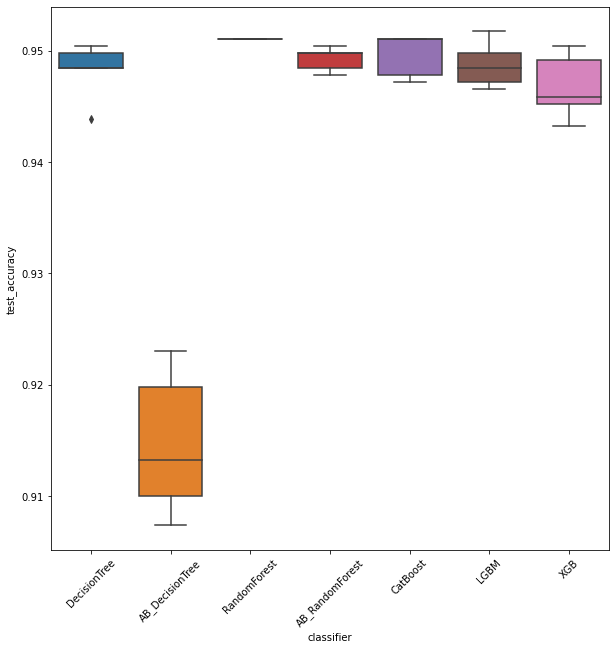

In [1589]:
plt.figure(figsize=(10,10))

fig = sns.boxplot(data = adf, x = "classifier", y = "test_accuracy")
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

In [1561]:
adf.groupby("classifier").mean().sort_values(ascending=False, by = "test_accuracy")

test_accuracy
classifier                    
RandomForest          0.951076
AB_RandomForest       0.949119
DecisionTree          0.949119
CatBoost              0.948963
LGBM                  0.948571
XGB                   0.945910
AB_DecisionTree       0.914286

In [1585]:
# testování nového pacienta
pacient_zero = pd.DataFrame.from_dict({"age": [79.0],
                                       "hypertension": [1], 
                                       "heart_disease":[0], 
                                       "avg_glucose_level": [174.12],
                                       "bmi": [24.00],
                                       "FS": [0],
                                       "married": [1],
                                       "residence": [0]})
res = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
for classifier in classifiers :
        x = classifier.fit(X_train, y_train)
        new = x.predict(pacient_zero)
        res.append(new[0])

for i, num in enumerate(res):
    if num == 0:
        res[i] = 'Healthy'
    else:
        res[i] = 'Stroke'
res            

[19:22:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['Healthy', 'Stroke', 'Healthy', 'Stroke', 'Stroke', 'Stroke', 'Stroke']

# K-means shlukování

In [1515]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'sex', 'married', 'residence',
       'FS', 'NS', 'S', 'cluster'],
      dtype='object')

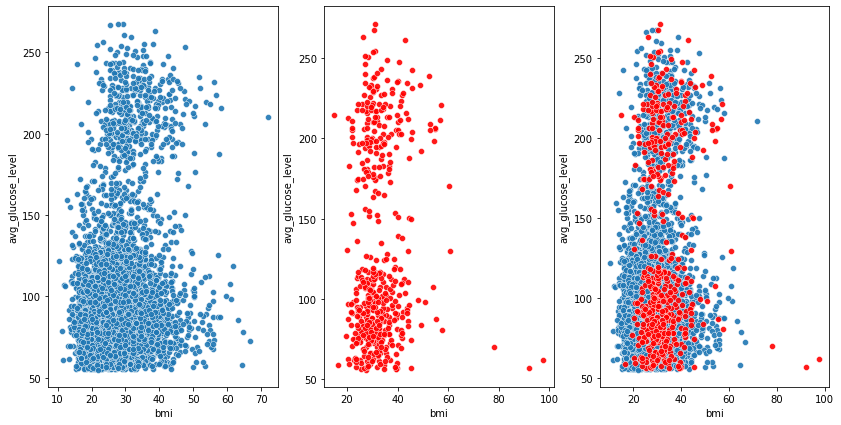

In [1516]:
fig, axs = plt.subplots(ncols= 3, figsize=(14,7))

g =sns.scatterplot(x="bmi", y="avg_glucose_level",
              data=df[df["hypertension"] == 0],
              sizes= 20,
              alpha = 0.9,
              ax=axs[0])

g =sns.scatterplot(x="bmi", y="avg_glucose_level",
              data=df[df["hypertension"] == 1],
              sizes= 20,
              alpha = 0.9,
              ax=axs[1],
              color='r')

g =sns.scatterplot(x="bmi", y="avg_glucose_level",
              data=df[df["hypertension"] == 0],
              sizes= 20,
              alpha = 0.9,
              ax=axs[2])

g =sns.scatterplot(x="bmi", y="avg_glucose_level",
              data=df[df["hypertension"] == 1],
              sizes= 20,
              alpha = 0.9,
              ax=axs[2],
              color='r')

In [1517]:
cus = df[["bmi", "avg_glucose_level"]]

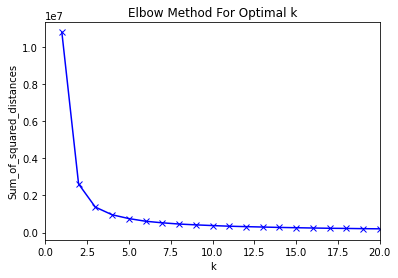

In [1518]:
sum_of_squared_distances = []
K = range(1,30)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(cus)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(range(1, (len(sum_of_squared_distances) + 1)), sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xlim((0,20))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [1519]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(cus)
kmeansLabels = kmeans.predict(cus)

In [1520]:
df["cluster"] = kmeansLabels

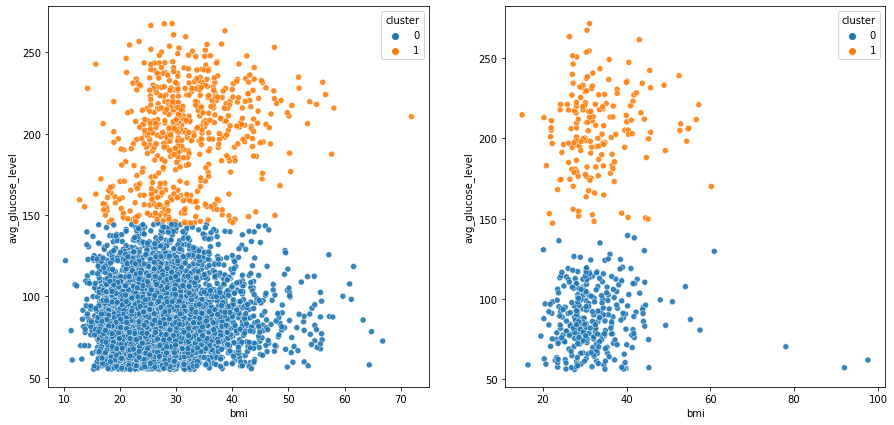

In [1521]:
fig, axs = plt.subplots(ncols= 2, figsize=(15,7))

g =sns.scatterplot(x="bmi", y="avg_glucose_level",
              data=df[df["hypertension"] == 0],
              sizes= 20,
              alpha = 0.9,
              hue = "cluster",     
              ax=axs[0])

g =sns.scatterplot(x="bmi", y="avg_glucose_level",
              data=df[df["hypertension"] == 1],
              sizes= 20,
              alpha = 0.9,
              ax=axs[1],
              hue = "cluster", 
              color='r')


In [1522]:
# výskyt hypertenze v identifikovaných shlucích
df[['cluster', 'hypertension']].groupby(['cluster'], as_index=False).mean()

cluster  hypertension
0        0      0.073784
1        1      0.230570